 # Day 5 Hyperparameters and Model Validation
模型验证(model validation)其实很简单，就是在选择模型和超参数之后，通过对训练数
据进行学习，对比模型对已知数据的预测值与实际值的差异。

## Model Validation
### 1. 错误的验证方法

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X, y)
y_model = model.predict(X)

from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

**准确率100%，可能吗？**
<br>根本缺陷:它用同一套数据训练和 评估模型。另外，最近邻模型是一种与距离相关的评估器，只会简单地存储训练数据，然 后把新数据与存储的已知数据进行对比来预测标签。在理想情况下，模型的准确率总是 100%。

### 2. 模型验证正确方法:留出集(holdout set)
先从训练模型 的数据中留出一部分，然后用这部分留出来的数据来检验模型性能。
<br>不过，用留出集进行模型验证有一个缺点，就是模型失去了一部分训练机会。

In [2]:
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.5)
model.fit(X1, y1)
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

/Users/har/py/virtualenv/data_analysis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.9066666666666666

### 3.交叉检验(cross-validation)
交叉检验，也就是做一组拟合，让数据的每个子集既是训练集，又 是验证集.
<br>这种形式的交叉检验被称为两轮交叉检验——将数据集分成两个子集，依次将每个子 集作为验证集。
<br> 当然，可以通过扩展这个概念，在数据中实现更多轮的实验
<br>如下，是一个用用 Scikit-Learn实现的五轮交叉检验

In [3]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

Scikit-Learn 为不同应用场景提供了各种交叉检验方法，都以迭代器(iterator)形式在 model_selection 模块中实现。
<br>例如，我们可能会遇到交叉检验的轮数与样本数相同的极 端情况，也就是说我们每次只有一个样本做测试，其他样本全用于训练。这种交叉检验类 型被称为 LOO(leave-one-out，只留一个)交叉检验:

In [4]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model,  X,  y,  cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

由于我们有 150 个样本，留一法交叉检验会生成 150 轮试验，每次试验的预测结果要么成 功(得分 1.0)，要么失败(得分 0.0)
<br>计算所有试验准确率的均值就可以得到模型的预测 准确性了:

In [5]:
scores.mean()

0.96

## Selecting the Best Model
### 1. 偏差与方差的均衡
**“最优模型”的问题基本可以看成是找出偏差与方差平衡点的问题。**

比如，给一些离散点。
1. 假定其为线性关系，模拟为一条直线。但由于数据本质上比直线要复杂，直线永远不可能很好地描述这份数据。这样的模型被认为是对数据<font color=red>**欠拟合**</font>;也就是说，模型没有足够的 灵活性来适应数据的所有特征。另一种说法就是模型具有<font color=red>**高偏差**</font>。
2. 认为它并非简单的线性关系，用高阶多项式来拟合数据。虽然这个模型有足够的灵活性可以近乎完美地适应数据的所有特征，但与其说它是十分准确地描述了训练数据，不如说它是过多地学习了数据的噪音，而不是数据的本质属性。这样的模型被认为是对数据<font color=red>**过拟合**</font>，也就是模型过于灵活，在适应数据所有特征的同时，也适应了随机误差。另一种说法就是模型 具有<font color=red>**高方差**</font>。

<br>• 对于高偏差模型，模型在验证集的表现与在训练集的表现类似。
<br>• 对于高方差模型，模型在验证集的表现远远不如在训练集的表现。

In [6]:
from sklearn.preprocessing import PolynomialFeatures # 多项式回归模型
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
#在 Scikit-Learn 中，可以用一个带多项式预处 理器的简单线性回归模型实现。我们将用一个管道命令来组合这两种操作

def PolynomialRegression(degree=2, **kwargs):
    """Generate a new feature matrix consisting of all polynomial combinations of the features with degree
      less than or equal to the specified degree. For example, if an input sample is two dimensional and of 
      the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2]."""
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

import numpy as np

def make_data(N, err=1.0, rseed=1): 
    """随机抽样数据"""
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1) #numpy.ravel:Return a contiguous flattened array.Equivalent to reshape(-1, order=order).
    if err > 0:
        y += err * rng.randn(N)
        return X, y
    
X, y = make_data(40)
print(X.shape, y.shape)

(40, 1) (40,)


### 2. Scikit-Learn验证曲线

/Users/har/py/virtualenv/data_analysis/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


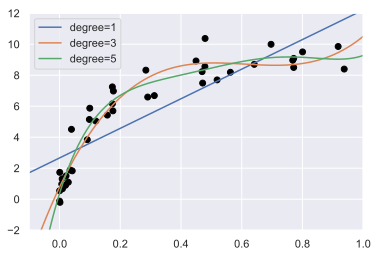

In [7]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # 设置图形样式
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

X_test = np.linspace(-0.1, 1.1, 500)[:, None]
plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

这个例子中控制模型复杂度的关键是多项式的次数，所以：究竟多项式的次数是多少，才能在偏差(欠拟合)与方差(过拟合)间达 到平衡?

可以通过可视化验证曲线来回答这个问题——利用 Scikit-Learn 的 <font color='red'> validation_curve </font> 函数就可以非常简单地实现。
<br>只要提供模型、数据、参数名称和验证范围信息，函数就会 自动计算验证范围内的训练得分和验证得分

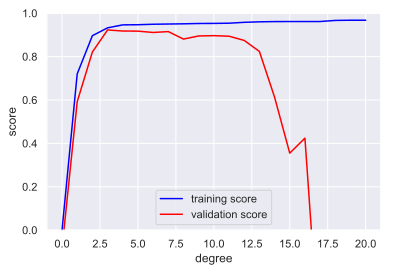

In [8]:
from sklearn.model_selection import validation_curve

degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                                         'polynomialfeatures__degree',
                                                         degree, cv=7)
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

训练得分总是比验证得分高;训练得分随着模型复 杂度的提升而单调递增;验证得分增长到最高点后由于过拟合而开始骤降
<br>从验证曲线中可以看出，偏差与方差均衡性最好的是三次多项式。我们可以计算结果，并 将模型画在原始数据上:

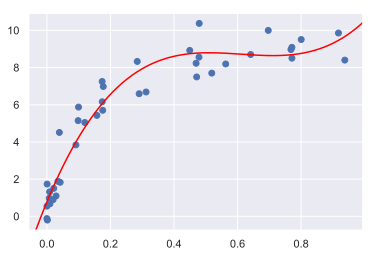

In [9]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test, c='red');
plt.axis(lim);

### Learning Curves 
** 反映训练集规模的训练得分 / 验证得分曲 线被称为学习曲线(learning curve)。** <br>
学习曲线的特征包括以下三点。<br>
• 特定复杂度的模型对较小的数据集容易过拟合:此时训练得分较高，验证得分较低。<br>
• 特定复杂度的模型对较大的数据集容易欠拟合:随着数据的增大，训练得分会不断降低，而验证得分会不断升高。<br>
• 模型的验证集得分永远不会高于训练集得分:两条曲线一直在靠近，但永远不会交叉。<br>
学习曲线最重要的特征是，随着训练样本数量的增加，分数会收敛到定值。因此，一旦你
的数据多到使模型得分已经收敛，那么增加更多的训练样本也无济于事!

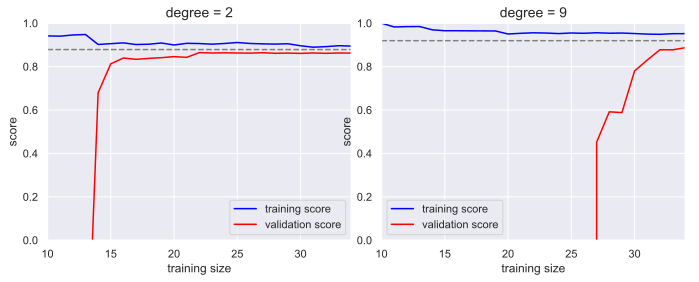

In [10]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                                     X, y, cv=7,
                                                     train_sizes=np.linspace(0.3, 1, 25))
    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray', linestyle='dashed')
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

由上图可看出，当你的学习曲线已经收敛时(即训练曲线和验证曲线已经贴在一起)，再怎么增加训练数据也不能再显著改善拟合效果!
<br>提高收敛得分的唯一办法就是换模型(通常也是更复杂的模型)。如右图所示:采用复杂 度更高的模型之后，虽然学习曲线的收敛得分提高了(对比虚线所在位置)，但是模型的方差也变大了(对比训练得分与验证得分的差异即可看出)。如果我们为复杂度更高的模 型继续增加训练数据，那么学习曲线最终也会收敛。

### 验证实践：网格搜索
下面是用网格搜索寻找 最优多项式回归模型的示例。我们将在模型特征的三维网格中寻找最优值——包括多项式 的次数的搜索范围、回归模型是否拟合截距，以及回归模型是否需要进行标准化处理。

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
                     'linearregression__fit_intercept': [True, False],
                     'linearregression__normalize': [True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

grid.fit(X, y)

In [ ]:
grid.best_params_ #获取最优参数